<a href="https://colab.research.google.com/github/levutb2004/deep_learning_uet/blob/main/BBC_Text_Classification_with_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import libraries

In [1]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import re
import tqdm
import seaborn as sns
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding
import string
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from warnings import filterwarnings
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
filterwarnings('ignore')
from pyvi import ViTokenizer

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10720319788510998615
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3148431955277046359
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

data cleaning

In [4]:
!wget -O /content/sample_data/Train_data.txt https://raw.githubusercontent.com/levutb2004/deep_learning_uet/main/Train_data.txt

--2024-12-09 15:58:28--  https://raw.githubusercontent.com/levutb2004/deep_learning_uet/main/Train_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28365287 (27M) [application/octet-stream]
Saving to: ‘/content/sample_data/Train_data.txt’

/content/sample_dat 100%[===================>]  27.05M   178MB/s    in 0.2s    

2024-12-09 15:58:29 (178 MB/s) - ‘/content/sample_data/Train_data.txt’ saved [28365287/28365287]



In [5]:
data = []
with open('/content/sample_data/Train_data.txt') as file:
    for line in file:
        parts = line.split(" ", 1)
        parts[0] = parts[0].replace("__label__", "")
        data.append(parts)
print(data[0])

['Du_lich', 'Theo hành trình tour du lịch Mỹ - Bờ Đông, du khách của Lữ hành Saigontourist sẽ đến New York - giấc mơ được gọi tên của hàng triệu người - chinh phục du khách bằng tượng đài Nữ thần Tự do duyên dáng trên vịnh Hudson, trung tâm Manhattan - trụ sở tài chính lớn nhất thế giới với phố Wall, khu Rockeffeler...Và thủ đô Washington, dạo bước trên National Mall, du khách sẽ bị choáng ngợp bởi các công trình kỳ vĩ nơi đây. Từ điện Capitol, tượng đài Lincoln, đài tưởng niệm Washington... cho đến Nhà Trắng, mỗi công trình đều là một tuyệt tác kiến trúc được phối cảnh hài hòa khiến cho Washington DC từ lâu đã được ghi nhận là một trong những thành phố đẹp nhất Hợp chủng quốc Hoa Kỳ. Đặc biệt hơn khi đi du lịch Mỹ, đến bất kỳ thành phố nào vào bất cứ thời gian nào, du khách cũng có thể trải nghiệm thú vui mua sắm bất tận…  http://www.dulichtet.com/nuoc-ngoai/4253/\n']


In [6]:
df = pd.DataFrame(data, columns=["category", "text",])
df

,category,text
0,Du_lich,"Theo hành trình tour du lịch Mỹ - Bờ Đông, du ..."
1,Nha_dat,mình cần tìm 1 phòng cho khoảng 3 người quanh...
2,Nha_dat,Cho thuê nhà riêng dt 60m/sàn. Có 4 phòng ngủ...
3,Nha_dat,"Cho thuê nhà ở tầng 4 khép kín, 4/295 Nguyễn K..."
4,Mua_sam,► Crumpler jackpack full photo ► giá : 800.000...
...,...,...
15995,Do_an_va_do_uong,CÁC MÓN KIM CHI NGON CHO MÙA THU -------------...
15996,Nha_dat,Cần cho thuê Chung cư Greenstar 234 Phạm Văn Đ...
15997,Kinh_doanh_va_Cong_nghiep,CHƯƠNG TRÌNH HỌC PHÍ THÁNG 08/2016 TẶNG NGAY ...
15998,Nha_va_vuon,Bố trí thông minh giúp nhà ống Sài Gòn không c...


In [7]:
df.isna().sum()

,0
category,0
text,0


In [8]:
df['text'] = df['text'].str.lower()

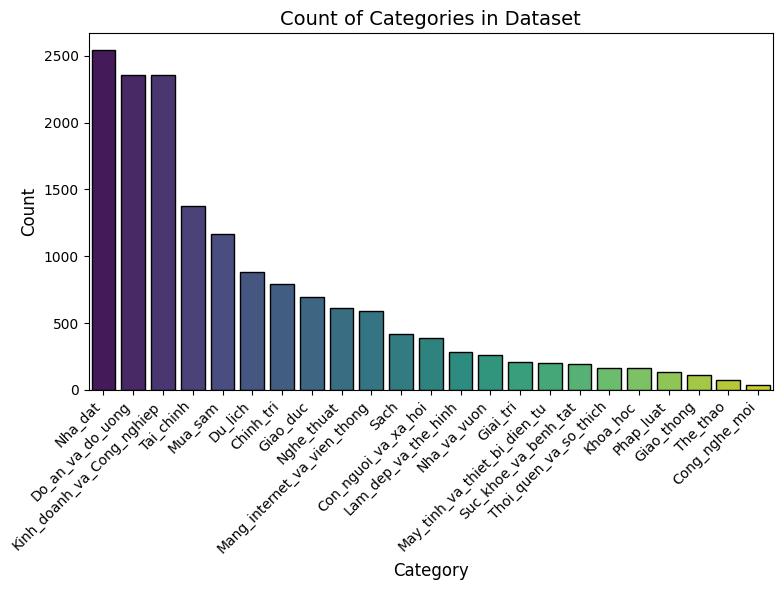

In [9]:
# Count of categories
category_counts = df['category'].value_counts()

# Plot the count of categories
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", edgecolor="black")
plt.title("Count of Categories in Dataset", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
# train_test_split
x_train, x_test = train_test_split(df, random_state=1, test_size=0.2)
x_train.shape, x_test.shape

((12800, 2), (3200, 2))

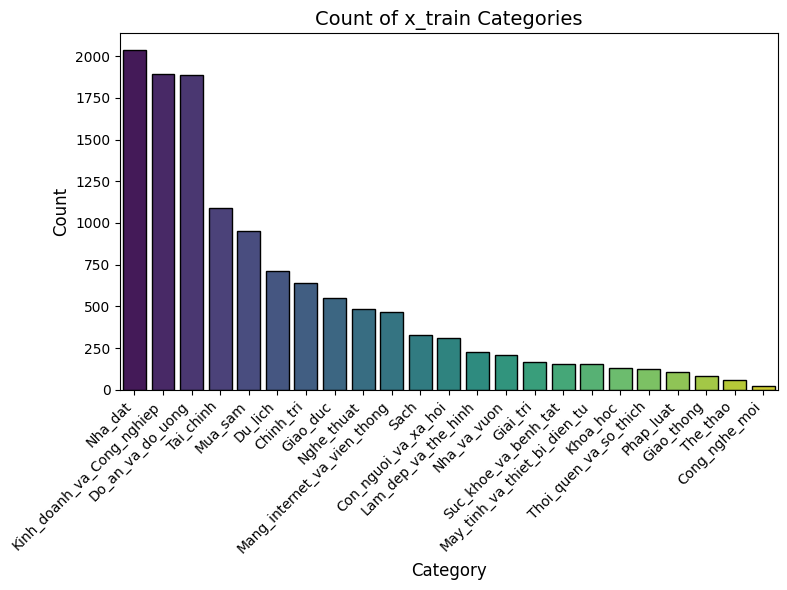

In [11]:
# Count of categories
category_counts = x_train['category'].value_counts()

# Plot the count of categories
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", edgecolor="black")
plt.title("Count of x_train Categories", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

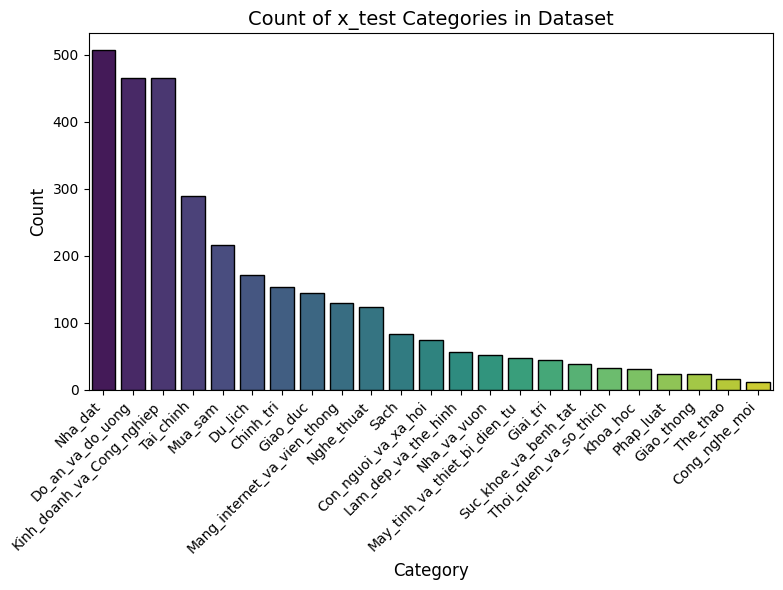

In [12]:
# Count of categories
category_counts = x_test['category'].value_counts()

# Plot the count of categories
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", edgecolor="black")
plt.title("Count of x_test Categories in Dataset", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [13]:
x_train['category']


,category
883,Chinh_tri
11157,Sach
5261,Mang_internet_va_vien_thong
1407,Tai_chinh
4253,Kinh_doanh_va_Cong_nghiep
...,...
905,Kinh_doanh_va_Cong_nghiep
5192,Phap_luat
12172,Nha_dat
235,Kinh_doanh_va_Cong_nghiep


In [14]:
y_test = x_test['category']
x_test = x_test['text']

In [15]:
y_train = x_train['category']
x_train = x_train['text']

In [16]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [17]:
def remove_punch(data):
    cleaned_data = []
    for sentences in data:
        new_sentence = sentences.translate(str.maketrans('','',string.punctuation))
        new_sentence = re.sub(r"[\n\t]*", "", new_sentence)
        new_sentence = re.sub('  ', " ", new_sentence)

        cleaned_data.append(new_sentence)
    return np.array(cleaned_data)

In [18]:
removed_punch_x_train = remove_punch(x_train)
x_train.shape, removed_punch_x_train.shape

((12800,), (12800,))

In [19]:
removed_punch_x_test = remove_punch(x_test)
x_test.shape, removed_punch_x_test.shape

((3200,), (3200,))

In [20]:
x_test

,text
0,[café ceo] văn hoá doanh nghiệp là cái mỏ neo ...
1,☀ balo korea+ bl132 ☀ ► giá : 395.000 vnđ ♨ in...
2,mn cho mình hỏi: công ty hình thức kinh doanh ...
3,một người singapore làm bằng 15 người việt ng...
4,bán sàn tttm tầng 1 dự án xuân la west lake bộ...
...,...
3195,bản tin tài chính kinh doanh tối 27/6 1. tin t...
3196,[ tổng hợp thiên đường ăn ngon khu vực hà đông...
3197,"nghèo không đáng sợ, nghèo cần phải suy nghĩ đ..."
3198,"đến dubai, cắm trại giữa sa mạc safari, tại sa..."


In [21]:
x_test[0][:350], '........................',removed_punch_x_test[0][:350]

('[café ceo] văn hoá doanh nghiệp là cái mỏ neo hay con rùa, tuỳ thuộc vào trình của lãnh đạo  văn hoá doanh nghiệp không phải là một cây cột bất định. nó có thể là chiếc mỏ neo được cắm chặt xuống đất với mục đích ổn định nền tảng, ổn định vị trí, nhưng khi cần thiết thì doanh nghiệp buộc phải "rút" lên để di chuyển, để tiến bước phát triển mạnh mẽ,',
 '........................',
 'café ceo văn hoá doanh nghiệp là cái mỏ neo hay con rùa tuỳ thuộc vào trình của lãnh đạo văn hoá doanh nghiệp không phải là một cây cột bất định nó có thể là chiếc mỏ neo được cắm chặt xuống đất với mục đích ổn định nền tảng ổn định vị trí nhưng khi cần thiết thì doanh nghiệp buộc phải rút lên để di chuyển để tiến bước phát triển mạnh mẽ nếu không ')

In [22]:
print(f'train: {removed_punch_x_train.shape},\ntest:, {removed_punch_x_test.shape}')

train: (12800,),
test:, (3200,)


In [25]:
def text_vizual(category,data_train):
    text = ''
    for txt in tqdm.tqdm(data_train[y_train==f'{category}']):
        text +=txt
    wordcloud_spam = WordCloud(background_color="white").generate(text)
    # Lines 2 - 5
    plt.figure(figsize = (15,15))
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'The most used words of category {category}')
    plt.show()

100%|██████████| 2035/2035 [00:01<00:00, 1444.55it/s]


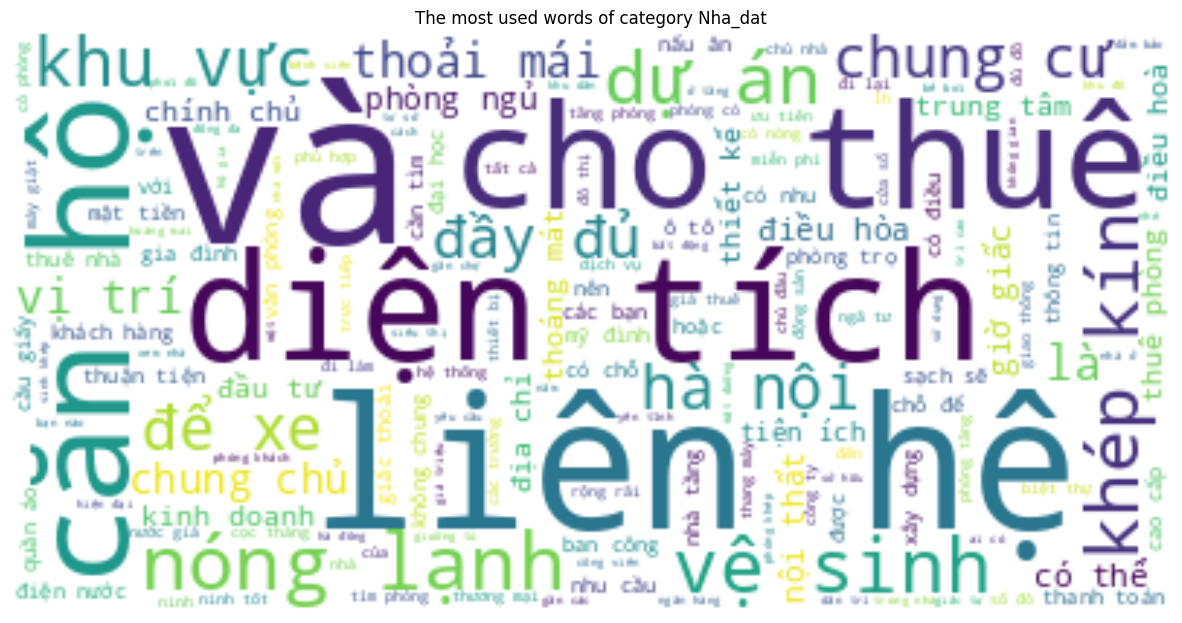

In [26]:
text_vizual('Nha_dat', removed_punch_x_train)

100%|██████████| 464/464 [00:00<00:00, 8408.76it/s]


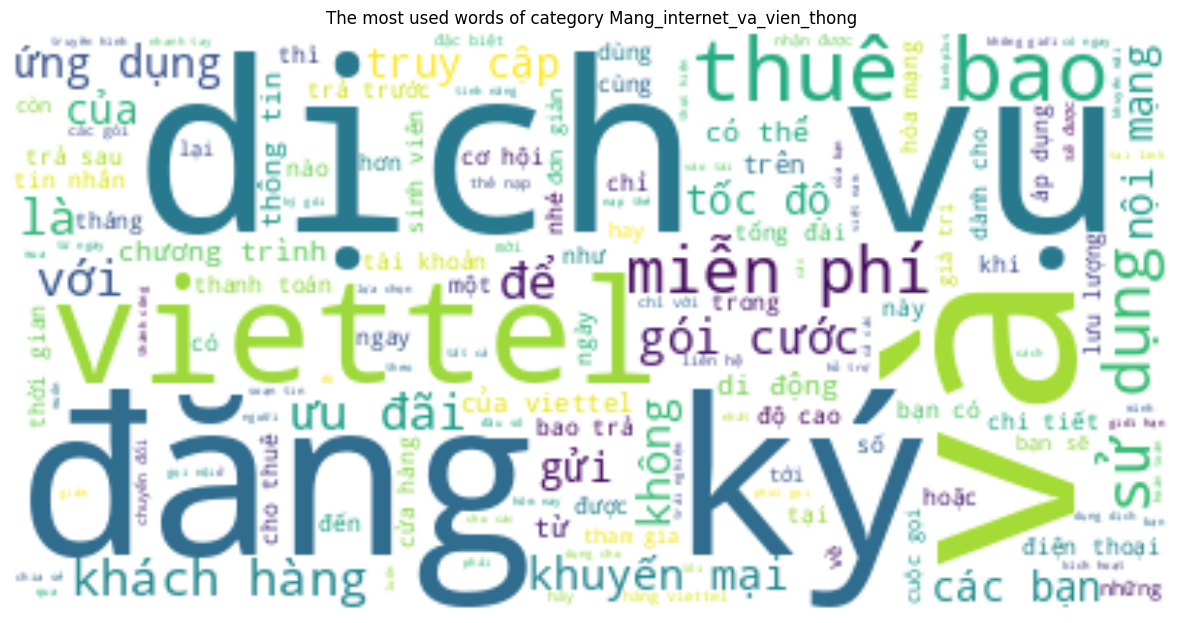

In [27]:
text_vizual('Mang_internet_va_vien_thong', removed_punch_x_train)

## removing stop words

In [28]:
!wget -O /content/sample_data/vietnamese-stopwords.txt https://raw.githubusercontent.com/levutb2004/deep_learning_uet/main/vietnamese-stopwords.txt

--2024-12-09 16:13:20--  https://raw.githubusercontent.com/levutb2004/deep_learning_uet/main/vietnamese-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘/content/sample_data/vietnamese-stopwords.txt’

/content/sample_dat 100%[===================>]  20.00K  --.-KB/s    in 0.002s  

2024-12-09 16:13:20 (11.9 MB/s) - ‘/content/sample_data/vietnamese-stopwords.txt’ saved [20475/20475]



In [29]:
with open('/content/sample_data/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

In [30]:
print(stopwords[:10])

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']


In [31]:
def remove_stop_words(data):
    cleaned_data = []
    for sentences in data:
        tokenized = ViTokenizer.tokenize(sentences).split(" ")
        new_sentence =  [token for token in tokenized  if token not in stopwords]
        sent = ''
        for text in new_sentence:
            sent+=text + ' '
        cleaned_data.append(sent)
    return np.array(cleaned_data)

In [32]:
cleaned_x_train = remove_stop_words(removed_punch_x_train)

In [33]:
cleaned_x_test = remove_stop_words(removed_punch_x_test)

In [34]:
cleaned_x_train.shape, cleaned_x_test.shape

((12800,), (3200,))

## vizualizing cleaned text

100%|██████████| 331/331 [00:00<00:00, 4296.25it/s]


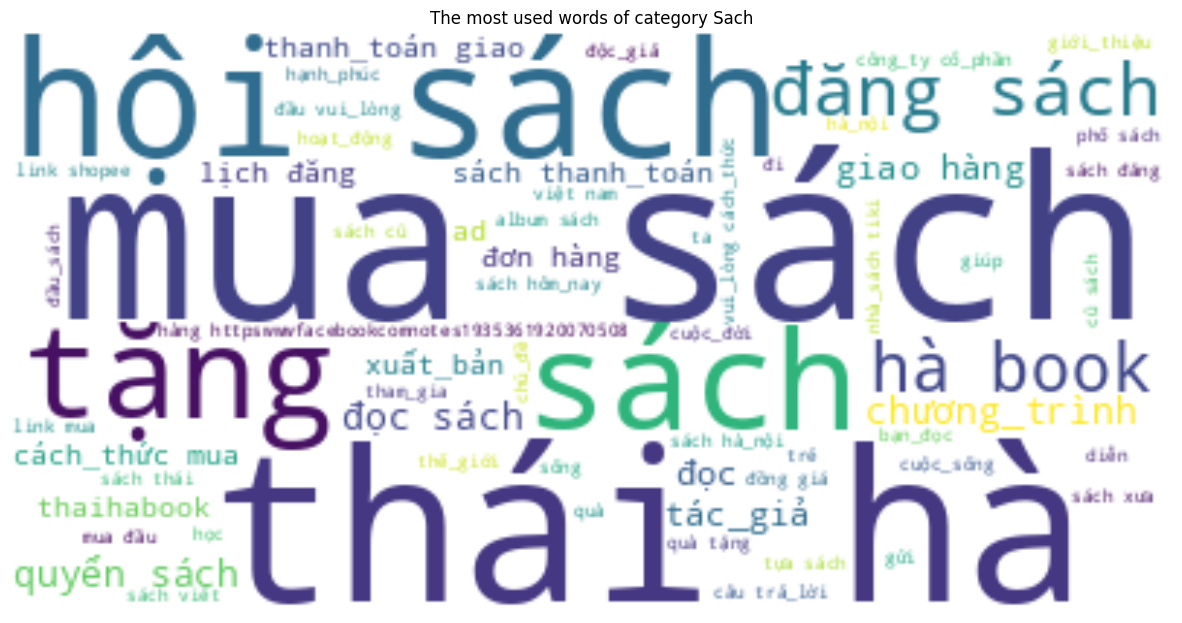

In [36]:
text_vizual('Sach', cleaned_x_train)

## before removing stopwords

100%|██████████| 331/331 [00:00<00:00, 5030.07it/s]


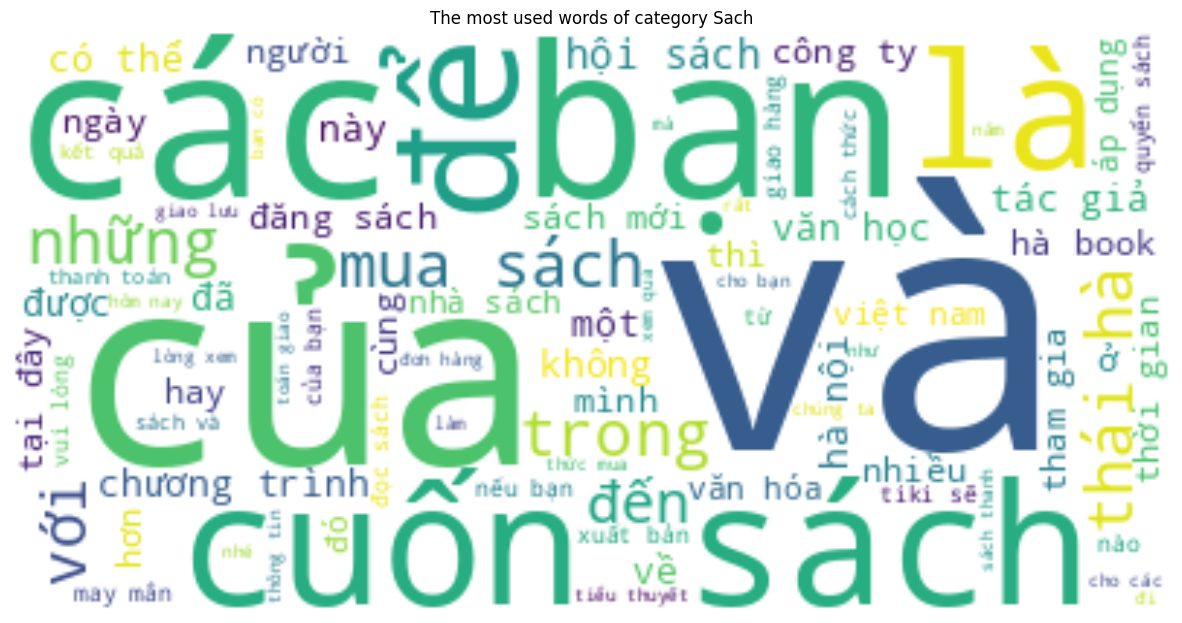

In [37]:
text_vizual('Sach', removed_punch_x_train)

## label encode target features

In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [40]:
le.classes_

array(['Chinh_tri', 'Con_nguoi_va_xa_hoi', 'Cong_nghe_moi',
       'Do_an_va_do_uong', 'Du_lich', 'Giai_tri', 'Giao_duc',
       'Giao_thong', 'Khoa_hoc', 'Kinh_doanh_va_Cong_nghiep',
       'Lam_dep_va_the_hinh', 'Mang_internet_va_vien_thong',
       'May_tinh_va_thiet_bi_dien_tu', 'Mua_sam', 'Nghe_thuat', 'Nha_dat',
       'Nha_va_vuon', 'Phap_luat', 'Sach', 'Suc_khoe_va_benh_tat',
       'Tai_chinh', 'The_thao', 'Thoi_quen_va_so_thich'], dtype=object)

In [41]:
y_train = le.transform(y_train)
y_test =  le.transform(y_test)

In [42]:
y_train = to_categorical(y_train,23)
y_test = to_categorical(y_test,23)

## Tokenize

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
tokenizer = Tokenizer()

In [45]:
allDocs = list(cleaned_x_train) + list(cleaned_x_test)
tokenizer.fit_on_texts(allDocs)

In [46]:
tokenizer.document_count

16000

In [51]:
document_count = tokenizer.document_count
vocab_size = len(tokenizer.word_index)
print(f'document_count: {document_count}\nvocab_size: {vocab_size}')

document_count: 16000
vocab_size: 60121


In [52]:
allDocs_sequence = tokenizer.texts_to_sequences(allDocs)
max_length = max([ len(x) for x in allDocs_sequence])
max_length

5206

In [53]:
train_sequences = tokenizer.texts_to_sequences(list(cleaned_x_train))
test_sequences = tokenizer.texts_to_sequences(list(cleaned_x_test))

In [54]:
train_sequences[0]

[1885,
 1885,
 161,
 7,
 12625,
 9337,
 408,
 1549,
 175,
 87,
 181,
 934,
 408,
 167,
 24,
 96,
 402,
 551,
 2166,
 15,
 66,
 365,
 395,
 2832,
 408,
 666,
 1229,
 33,
 202,
 223,
 6273,
 1997,
 161,
 483,
 122,
 85,
 4075,
 214,
 567,
 229,
 67,
 888,
 1014,
 59,
 20,
 2902,
 1809,
 966,
 277,
 39,
 166,
 891,
 455,
 1275,
 408,
 277,
 3636,
 4278,
 38,
 33,
 1118,
 897,
 402,
 102,
 461,
 164,
 33,
 20272,
 324,
 64,
 33,
 115,
 1814,
 408,
 976,
 836,
 1908,
 4232,
 4076,
 1208,
 918,
 39,
 2766,
 12626,
 2706,
 2956,
 190,
 4077,
 225,
 2601,
 2016,
 668,
 2957,
 918,
 218,
 1173,
 562,
 721,
 118,
 87,
 898,
 269,
 2171,
 1639,
 87,
 898,
 150,
 102,
 468,
 208,
 394,
 1898,
 3412,
 2322,
 1037,
 87,
 898,
 30,
 22,
 187,
 271,
 97,
 588,
 1045,
 208,
 618,
 271,
 97,
 30,
 22,
 83,
 286,
 184,
 2335,
 948]

In [55]:
# pad the sequences
train_padded = pad_sequences(train_sequences,padding='post', truncating = 'post', maxlen = max_length )
test_padded = pad_sequences(test_sequences,padding='post', truncating = 'post', maxlen = max_length )

In [56]:
train_padded.shape

(12800, 5206)

In [57]:
train_padded

array([[1885, 1885,  161, ...,    0,    0,    0],
       [  52,    2,   30, ...,    0,    0,    0],
       [1176, 2256,  477, ...,    0,    0,    0],
       ...,
       [ 132,  138,   70, ...,    0,    0,    0],
       [3790,  237, 1752, ...,    0,    0,    0],
       [ 179,  399, 2437, ...,    0,    0,    0]], dtype=int32)

In [58]:
test_padded.shape

(3200, 5206)

In [59]:
train_padded

array([[1885, 1885,  161, ...,    0,    0,    0],
       [  52,    2,   30, ...,    0,    0,    0],
       [1176, 2256,  477, ...,    0,    0,    0],
       ...,
       [ 132,  138,   70, ...,    0,    0,    0],
       [3790,  237, 1752, ...,    0,    0,    0],
       [ 179,  399, 2437, ...,    0,    0,    0]], dtype=int32)

In [60]:
train_padded.shape

(12800, 5206)

## Model

In [61]:
class Model(tf.keras.Model):
    def __init__(self, num_classes, shape):
        super().__init__()
        self.embedding = Embedding(vocab_size+1,num_classes, input_length=  max_length, name = 'embedded')
        self.lstm = LSTM(20,activation=tf.nn.tanh, return_sequences=True)
        self.flatten = Flatten()
        self.dense1 = Dense(32, activation='relu')
        self.output_dense = Dense(num_classes, activation= 'softmax')
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.output_dense(x)
model = Model(len(df['category'].unique()), train_padded.shape)

In [62]:
model.compile(optimizer='adam',metrics = ['accuracy'], loss = tf.keras.losses.CategoricalCrossentropy())

In [63]:
history  = model.fit(train_padded, y_train, epochs = 5)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - accuracy: 0.1363 - loss: 4.3807
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 53s 132ms/step - accuracy: 0.1473 - loss: 2.9073
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 128ms/step - accuracy: 0.1500 - loss: 2.7846
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.1471 - loss: 2.7196
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.1511 - loss: 2.6888


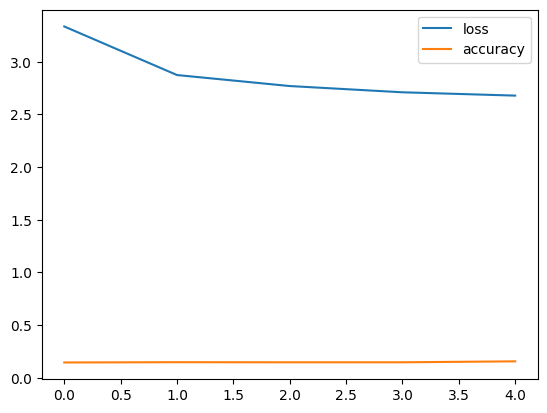

In [64]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

In [65]:
test_pred = model.predict(test_padded, verbose = 1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step


In [66]:
test_pred.argmax(axis=1)

array([15, 15, 15, ..., 15, 15, 15])

In [67]:
print(classification_report(y_test.argmax(axis=1), test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.00      0.00      0.00        75
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00       466
           4       0.00      0.00      0.00       171
           5       0.00      0.00      0.00        44
           6       0.00      0.00      0.00       145
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        31
           9       0.00      0.00      0.00       465
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00       129
          12       0.00      0.00      0.00        47
          13       0.00      0.00      0.00       216
          14       0.00      0.00      0.00       124
          15       0.16      1.00      0.27       507
          16       0.00      0.00      0.00        52
          17       0.00    

In [68]:
test_padded

array([[1600,  466,   52, ...,    0,    0,    0],
       [1072, 2749, 6197, ...,    0,    0,    0],
       [2308,    1,   56, ...,    0,    0,    0],
       ...,
       [1377,  831, 1377, ...,    0,    0,    0],
       [2185, 1911, 1781, ...,    0,    0,    0],
       [1246,  774,  217, ...,    0,    0,    0]], dtype=int32)

In [69]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
le.classes_

array(['Chinh_tri', 'Con_nguoi_va_xa_hoi', 'Cong_nghe_moi',
       'Do_an_va_do_uong', 'Du_lich', 'Giai_tri', 'Giao_duc',
       'Giao_thong', 'Khoa_hoc', 'Kinh_doanh_va_Cong_nghiep',
       'Lam_dep_va_the_hinh', 'Mang_internet_va_vien_thong',
       'May_tinh_va_thiet_bi_dien_tu', 'Mua_sam', 'Nghe_thuat', 'Nha_dat',
       'Nha_va_vuon', 'Phap_luat', 'Sach', 'Suc_khoe_va_benh_tat',
       'Tai_chinh', 'The_thao', 'Thoi_quen_va_so_thich'], dtype=object)

In [71]:
rnd = np.random.randint(0, len(test_padded))
test_single_data = test_padded[rnd]
y_single_data = y_test[rnd]
print(test_single_data)
print("*"*50)
print(y_single_data)
print(f'real_class: {le.classes_[y_single_data.reshape(1,-1).argmax(axis=1)[0]]}')
print(f'class_index: {y_single_data.reshape(1,-1).argmax(axis=1)[0]}')

[796 712 264 ...   0   0   0]
**************************************************
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
real_class: Mua_sam
class_index: 13


In [73]:
test_single_data_reshaped = test_single_data.reshape(1,5206)

In [74]:
single_predicted = model.predict(test_single_data_reshaped, verbose= 1)
single_predicted.argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


array([15])

**sport = 3 true prediction**

In [ ]:
model.save("/content/sample_data/text_categorization_model.h5", save_format='tf')